# BEATS KBLT tomopy recon test 00
#### Reconstruction of first KBLTdataset <br />
Author: [Gianluca Iori](mailto:gianluca.iori@sesame.org.jo)<br />
Created on: 06-11-2020 <br />
Modified on: 17-10-2021 <br />

see also:
https://tomopy.readthedocs.io/en/latest/ipynb/tomopy.html

#### Activate TomoPy kernel in Jupyter:
`conda env list`

`source activate tomopy`

`python -m ipykernel install --user --name tomopy_source --display-name "conda (tomopy_source)"`

`jupyter notebook &`

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import os
import dxchange
import tomopy
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
# import recon_utils

astropy module not found


In [3]:
matplotlib.rcParams['figure.dpi'] = 150

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

In [25]:
h5file = "/mnt/hdf/kblt_test_spring_01_324.h5"
h5file_darks = "/mnt/hdf/kblt_test_spring_01_darks_326.h5"
h5file_flats = "/mnt/hdf/kblt_test_spring_01_flats_327.h5"
path_recon = "/mnt/hdf/recon/kblt_test_spring_01/"

#### Read HDF5 data
- The `.read_aps_32id()` method of DXchange can read TOMCAT .h5 data
- If run without arguments (proj..), the import seem to be virtual (mem map)? I don't see this data in the RAM and I can reconstruct the whole volume on my laptop

In [6]:
# read the full proj
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0)

INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_324.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_324.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_324.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_324.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_324.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_324.h5


In [7]:
print(projs.shape[:])
print(projs.dtype)

(501, 2160, 2560)
uint16


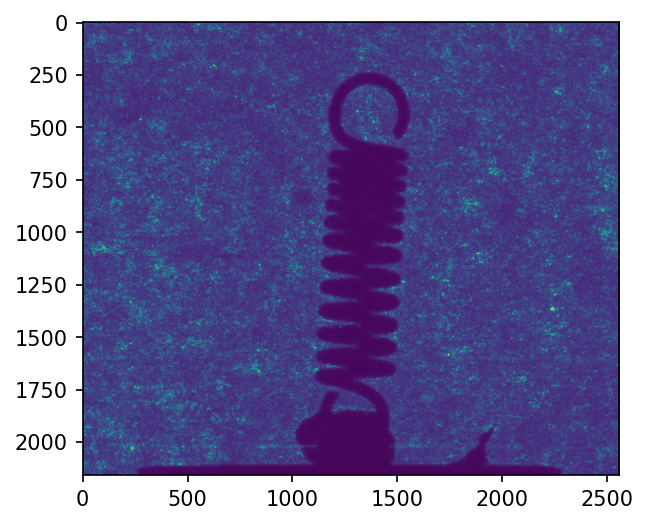

In [8]:
plt.imshow(projs[200, :, :])
plt.show()

Check if theta exists

In [ ]:
theta

If the angular information is not avaialable from the raw data you need to set the data collection angles. In this case, theta is set as equally spaced between 0-180 degrees.

In [10]:
if theta is None:
    theta = tomopy.angles(projs.shape[0])

#### Read flats and darks
Flats and darks were acquired in separate files

In [20]:
# read the flats
flats, tmp, tmp2, tmp3 = dxchange.read_aps_32id(h5file_flats)

INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_flats_327.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_flats_327.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_flats_327.h5
ERROR:dxchange.reader:Unrecognized hdf5 dataset: "exchange/theta"
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_flats_327.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_flats_327.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_flats_327.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_flats_327.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_flats_327.h5


In [23]:
print(flats.shape[:])

(10, 2160, 2560)


In [26]:
# read the darks
darks, tmp, tmp2, tmp3 = dxchange.read_aps_32id(h5file_darks)

INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_darks_326.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_darks_326.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_darks_326.h5
ERROR:dxchange.reader:Unrecognized hdf5 dataset: "exchange/theta"
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_darks_326.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_darks_326.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_darks_326.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_darks_326.h5
INFO:dxchange.reader:Data successfully imported: /mnt/hdf/kblt_test_spring_01_darks_326.h5


#### Crop data, flats and darks

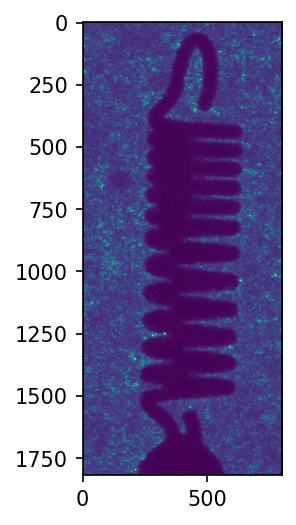

In [52]:
plt.imshow(projs[1, 200:2020, 900:1700])
plt.show()

In [53]:
projs_crop = projs[:, 200:2020, 900:1700]
flats_crop = flats[:, 200:2020, 900:1700]
darks_crop = darks[:, 200:2020, 900:1700]

#### Flat field correction

In [54]:
projs_crop_corr = tomopy.normalize(projs_crop, flats_crop, darks_crop)
# print(projs.dtype)

#### Calculate $ -log(projs) $ to linearize transmission tomography data.

In [57]:
projs_crop_corr = tomopy.minus_log(projs_crop_corr)

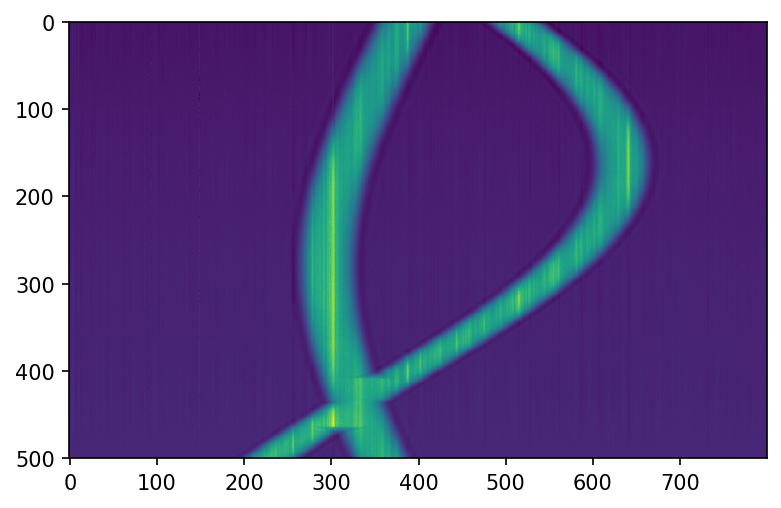

In [58]:
plt.imshow(projs_crop_corr[:, 200, :])
plt.show()

Free some space

In [ ]:
del projs

In [64]:
del projs_crop

In [67]:
clear flats

In [68]:
clear darks

#### Automatic detect Center Of Rotation (COR)

In [60]:
COR = tomopy.find_center(projs_crop_corr, theta, init=projs_crop_corr.shape[2]/2, ind=200, tol=0.5)
print(COR)

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...
INFO:tomopy.recon.rotation:Trying rotation center: [400.]
INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...
INFO:tomopy.recon.rotation:Function value = 1.618573
INFO:tomopy.recon.rotation:Trying rotation center: [420.]
INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...
INFO:tomopy.recon.rotation:Function value = 1.690733
INFO:tomopy.recon.rotation:Trying rotation center: [380.]
INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...
INFO:tomopy.recon.rotation:Function value = 1.457665
INFO:tomopy.recon.rotation:Trying rotation center: [360.]
INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...
INFO:tomopy.recon.rotation:Function value = 1.447495
INFO:tomopy.recon.rotation:Trying rotation center: [320.]
INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


[369.6875]


#### Reconstruction with CPU
|  |  |
| :--- | :--- |
| **Algorithm**      | `gridrec` |
| **COR**   | Auto COR from step above seems to have an offset |


In [69]:
recon = tomopy.recon(projs_crop_corr, theta, center=COR, algorithm='gridrec', sinogram_order=False)

MemoryError: Unable to allocate 4.34 GiB for an array with shape (1820, 800, 800) and data type float32

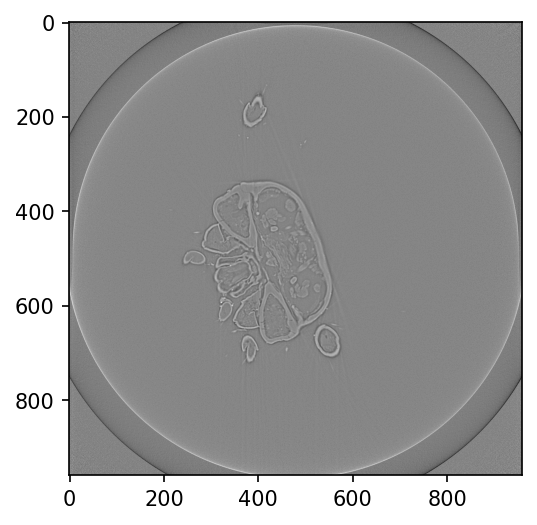

In [26]:
plt.imshow(recon[200, :, :], cmap='gray')
plt.show()

In [27]:
recon.dtype

dtype('float32')

#### GPU reconstruction (not tested yet)

In [16]:
# recon = tomopy.recon(projs, theta, center=COR+15, algorithm='sirt', sinogram_order=False, accelerated=True)

#### Apply circular mask

In [23]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

Visualize results

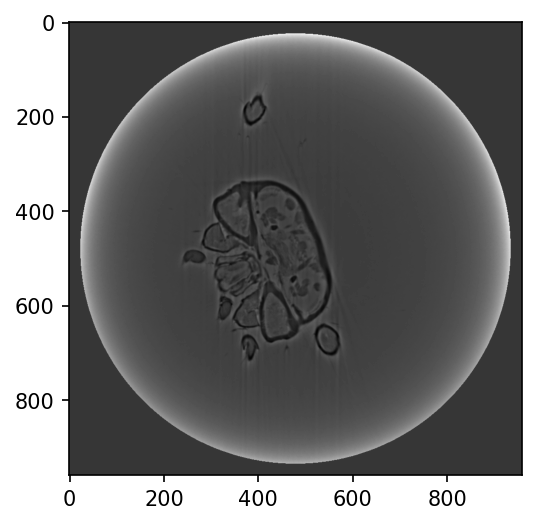

In [24]:
plt.imshow(recon[200, :, :], cmap='gray')
plt.show()

#### Scale to 0-255 (`uint8`)
The uint8 GV range for output slices can cover the full float32 range or be selected based on the 3D data histogram

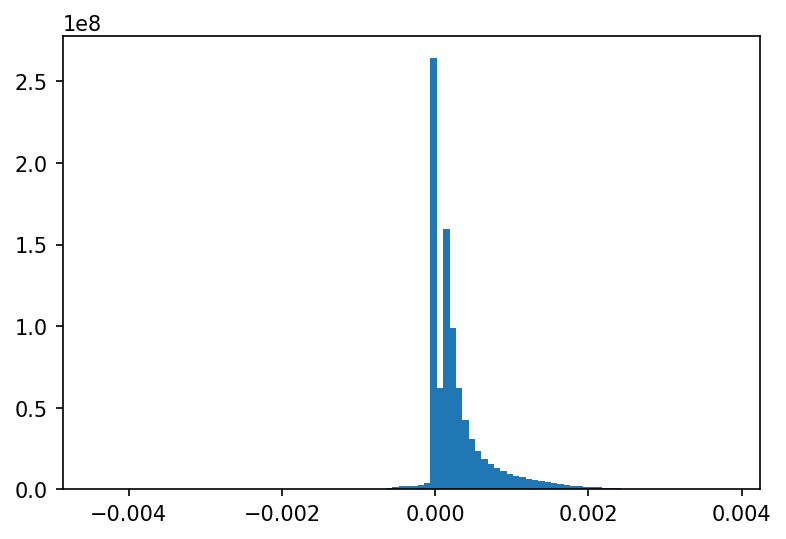

In [25]:
plt.hist(recon.ravel(), bins=100)
plt.show()

In [26]:
# uint8 GV range from data histogram (0.01 and 0.99 quantiles)
[range_min, q_95] = 1.1*np.quantile(recon.ravel(), [0.01, 0.99])
range_max = q_95 - range_min
print(range_min, range_max)

-0.0002488091049599461 0.0023408164326683607


In [28]:
# uint8 GV range as MIN and MAX of 3D data
range_min = np.min(recon)
range_max = np.max(recon)
range_max = range_max - range_min

In [29]:
recon_uint8Range = 255*((recon - range_min)/range_max)

In [28]:
recon_uint8Range[recon_uint8Range < 0] = 0

In [29]:
recon_uint8Range[recon_uint8Range > 255] = 255

In [30]:
# apply again circ mask
recon_uint8Range = tomopy.circ_mask(recon_uint8Range, axis=0, ratio=0.95)

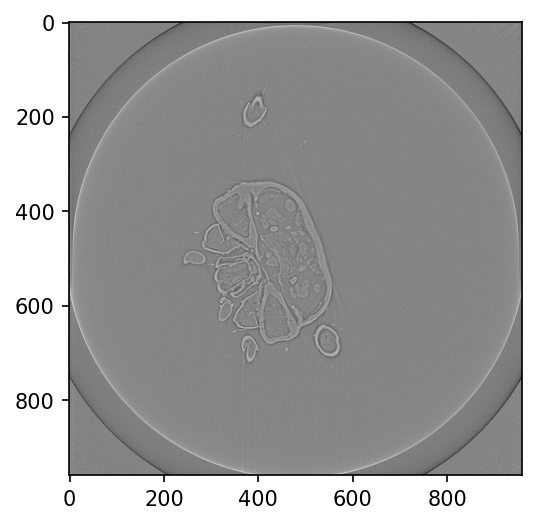

In [30]:
plt.imshow(recon_uint8Range[200, :, :], cmap='gray')
plt.show()

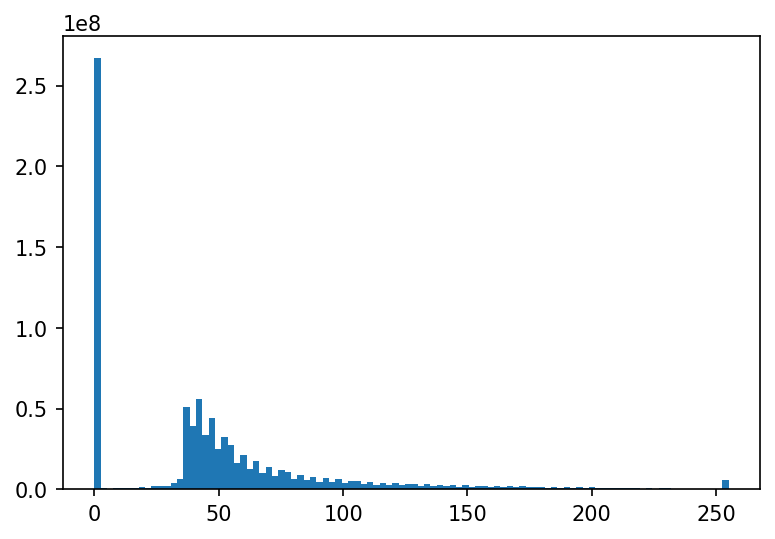

In [32]:
plt.hist(recon_uint8Range.round().ravel(), bins=100)
plt.show()

#### Write output Tiff stack as `uint8`

In [34]:
fileout = path_recon+'data.tiff'
dxchange.writer.write_tiff_stack(recon_uint8Range, fname=fileout, dtype='uint8', axis=0, digit=5, start=0, overwrite=True)

#### Open virtual stack in ImageJ

In [19]:
os.system(Fiji_exe_stack + '/home/gianthk/Data/StefanFly_test/test_00_/rec_8bit_0/test_00_001.rec.8bit.tif &')

0

#### Save images reconstructed with a range of rotation centers.

In [35]:
tomopy.write_center(projs, theta, dpath=path_recon+'tmp/COR', cen_range=[COR-10, COR+10, 1], ind=500, mask=True, ratio=1.0, algorithm='gridrec', filter_name='parzen')

Reconstructing 20 slice groups with 8 master threads...


View them in Fiji

In [64]:
os.system(Fiji_exe_stack + path_recon+'tmp/COR/'+'{:04.2f}'.format(COR[0])+'.tiff &')

0

Optimize the reconstruction around given COR

In [67]:
tomopy.write_center(projs, theta, dpath=path_recon+'tmp/COR', cen_range=[482, 490, 0.5], ind=500, mask=True, ratio=1.0, algorithm='gridrec', filter_name='parzen')

Reconstructing 16 slice groups with 8 master threads...


View them in Fiji

In [69]:
os.system(Fiji_exe_stack + path_recon+'tmp/COR/482.00.tiff &')

0